In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.


# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [7]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [8]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [9]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [10]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [11]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [12]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

Problem 1a

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(7777)

def generator_loss(fake):
    
    return -torch.mean(torch.log(fake))
    
def discriminator_loss(fake, real):

    loss_real = -torch.mean(torch.log(real))
    loss_fake = -torch.mean(torch.log(1.0 - fake))
    return loss_real + loss_fake

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0

    ### Properly unpacking the tuple, unlike the original code ;)
    for bi, (reals_, _) in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):

        ### Discriminator step

        reals_ = reals_.to(device)
        
        batch_size_ = reals_.size(0)

        optim_d.zero_grad()

        ### Real data 
        #real_labels = label_real(batch_size_)
        output_r = discriminator(reals_)

        ### Fake data, sampled from p(z) by generator class
        ### Detaching because GPT-4 told me so while bugfixing
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise).detach()
        #fake_labels = label_fake(batch_size_)
        output_f = discriminator(fakes)

        ### Using the given equation
        loss_d_ = discriminator_loss(output_f, output_r)

        ### Update step
        loss_d_.backward()
        optim_d.step()
        
        loss_d += loss_d_.item()

        ### Generator tries to fool the discriminator, setting the labels to real
        ### -not- Generating new noise (Do I need to, or can I use previously generated noise?)
        optim_g.zero_grad()
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise)

        output_f_g = discriminator(fakes)


        loss_g_ = generator_loss(output_f_g)

        loss_g_.backward()

        optim_g.step()

        loss_g += loss_g_.item()
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) == 1 or (epoch + 1) == 5 or (epoch + 1) == 50 or (epoch + 1) == 100:
        plt.figure(figsize=(8,8))
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'Generated Images at Epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

Problem 1b

In [ ]:
### Implementing the method for part b
#Previous optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
torch.manual_seed(7777)

def generator_loss(fake):
    epsilon = 1e-8  
    return torch.mean(torch.log(1.0 - fake + epsilon))
    
def discriminator_loss(fake, real):

    loss_real = -torch.mean(torch.log(real))
    loss_fake = -torch.mean(torch.log(1.0 - fake))
    return loss_real + loss_fake

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0

    ### Properly unpacking the tuple, unlike the original code ;)
    for bi, (reals_, _) in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):

        ### Discriminator step

        reals_ = reals_.to(device)
        
        batch_size_ = reals_.size(0)

        optim_d.zero_grad()

        ### Real data 
        #real_labels = label_real(batch_size_)
        output_r = discriminator(reals_)

        ### Fake data, sampled from p(z) by generator class
        ### Detaching because GPT-4 told me so while bugfixing
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise).detach()
        #fake_labels = label_fake(batch_size_)
        output_f = discriminator(fakes)

        ### Using the given equation
        loss_d_ = discriminator_loss(output_f, output_r)

        ### Update step
        loss_d_.backward()
        optim_d.step()
        
        loss_d += loss_d_.item()

        ### Generator tries to fool the discriminator, setting the labels to real
        ### -not- Generating new noise (Do I need to, or can I use previously generated noise?)
        optim_g.zero_grad()
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise)

        output_f_g = discriminator(fakes)


        loss_g_ = generator_loss(output_f_g)
        loss_g_.backward()
        optim_g.step()
        loss_g += loss_g_.item()
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) == 1 or (epoch + 1) == 5 or (epoch + 1) == 50 or (epoch + 1) == 100:
        plt.figure(figsize=(8,8))
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'Generated Images at Epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images_p1b.gif', imgs)

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss_p1b.png')

Problem 1c

In [ ]:
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy loss

In [33]:
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [34]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [16]:
# learning parameters
batch_size = 512
epochs = 150
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from adabelief_pytorch import AdaBelief
optim_g = AdaBelief(generator.parameters(), lr=0.0001, eps=1e-16, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=True, rectify=True, print_change_log=False)
optim_d = AdaBelief(discriminator.parameters(), lr=0.0001, eps=1e-16, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=True, rectify=True, print_change_log=False)


Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


118it [00:38,  3.08it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


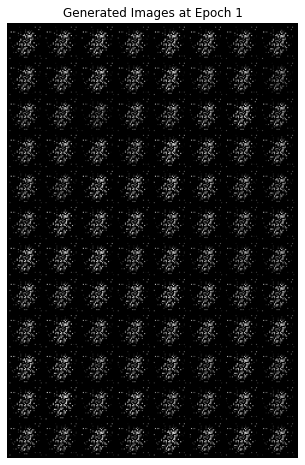

  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 1 of 100
Generator loss: 0.67434953, Discriminator loss: 1.15551473


118it [00:35,  3.33it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 2 of 100
Generator loss: 1.84054683, Discriminator loss: 0.58640752


118it [00:35,  3.34it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 3 of 100
Generator loss: 1.66903530, Discriminator loss: 0.98717342


118it [00:35,  3.36it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 4 of 100
Generator loss: 1.26173347, Discriminator loss: 1.26404797


118it [00:35,  3.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


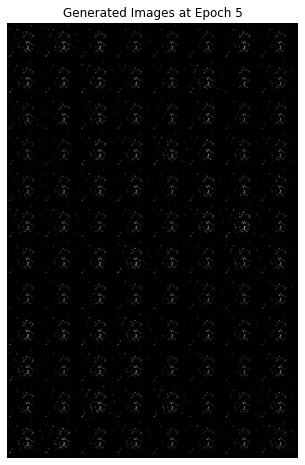

  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 5 of 100
Generator loss: 1.22563158, Discriminator loss: 1.04036650


118it [00:35,  3.32it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 6 of 100
Generator loss: 1.70445635, Discriminator loss: 1.09066856


118it [00:35,  3.33it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 7 of 100
Generator loss: 2.68731023, Discriminator loss: 0.70065577


118it [00:35,  3.32it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 8 of 100
Generator loss: 2.42800412, Discriminator loss: 1.08552174


118it [00:35,  3.31it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 9 of 100
Generator loss: 1.59986184, Discriminator loss: 1.14304543


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 10 of 100
Generator loss: 1.39772029, Discriminator loss: 1.11200632


118it [00:35,  3.32it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 11 of 100
Generator loss: 1.97143661, Discriminator loss: 0.92164929


118it [00:35,  3.33it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 12 of 100
Generator loss: 1.99420800, Discriminator loss: 0.97891816


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 13 of 100
Generator loss: 2.28643469, Discriminator loss: 0.80044918


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 14 of 100
Generator loss: 2.59623738, Discriminator loss: 0.73388604


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 15 of 100
Generator loss: 2.59231727, Discriminator loss: 0.67998297


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 16 of 100
Generator loss: 3.22852477, Discriminator loss: 0.55436791


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 17 of 100
Generator loss: 3.08008556, Discriminator loss: 0.52537268


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 18 of 100
Generator loss: 3.32579046, Discriminator loss: 0.39052793


118it [00:36,  3.27it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 19 of 100
Generator loss: 3.55097456, Discriminator loss: 0.50482829


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 20 of 100
Generator loss: 3.33458215, Discriminator loss: 0.51615144


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 21 of 100
Generator loss: 3.87614691, Discriminator loss: 0.33616507


118it [00:35,  3.31it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 22 of 100
Generator loss: 3.84073677, Discriminator loss: 0.28696255


118it [00:36,  3.27it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 23 of 100
Generator loss: 4.48474956, Discriminator loss: 0.27919629


118it [00:35,  3.30it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 24 of 100
Generator loss: 3.95382371, Discriminator loss: 0.45952120


118it [00:36,  3.28it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 25 of 100
Generator loss: 3.41896432, Discriminator loss: 0.49992609


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 26 of 100
Generator loss: 4.19400810, Discriminator loss: 0.35098388


118it [00:35,  3.31it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 27 of 100
Generator loss: 3.71087261, Discriminator loss: 0.40633205


118it [00:35,  3.29it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 28 of 100
Generator loss: 3.97212598, Discriminator loss: 0.47226403


118it [00:36,  3.27it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 29 of 100
Generator loss: 3.60749253, Discriminator loss: 0.44357067


118it [00:36,  3.28it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 30 of 100
Generator loss: 4.13813460, Discriminator loss: 0.31433224


118it [00:36,  3.27it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 31 of 100
Generator loss: 4.38207271, Discriminator loss: 0.54276052


118it [00:36,  3.25it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 32 of 100
Generator loss: 3.40451196, Discriminator loss: 0.47664255


118it [00:36,  3.28it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 33 of 100
Generator loss: 3.80400255, Discriminator loss: 0.37487034


118it [00:36,  3.26it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 34 of 100
Generator loss: 3.75474528, Discriminator loss: 0.37157617


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 35 of 100
Generator loss: 4.13050874, Discriminator loss: 0.30941292


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 36 of 100
Generator loss: 4.04841888, Discriminator loss: 0.33816141


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 37 of 100
Generator loss: 3.94196781, Discriminator loss: 0.38768821


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 38 of 100
Generator loss: 4.29787787, Discriminator loss: 0.34070649


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 39 of 100
Generator loss: 4.21880555, Discriminator loss: 0.25339315


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 40 of 100
Generator loss: 4.31712657, Discriminator loss: 0.29872947


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 41 of 100
Generator loss: 4.43347044, Discriminator loss: 0.34743058


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 42 of 100
Generator loss: 3.95164459, Discriminator loss: 0.38836266


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 43 of 100
Generator loss: 3.31759686, Discriminator loss: 0.43080523


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 44 of 100
Generator loss: 3.52071723, Discriminator loss: 0.38944815


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 45 of 100
Generator loss: 3.45661282, Discriminator loss: 0.39378534


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 46 of 100
Generator loss: 3.61683429, Discriminator loss: 0.38275541


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 47 of 100
Generator loss: 3.41906749, Discriminator loss: 0.42764594


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 48 of 100
Generator loss: 3.22960790, Discriminator loss: 0.44678517


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 49 of 100
Generator loss: 3.24327005, Discriminator loss: 0.43873179


118it [00:34,  3.43it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


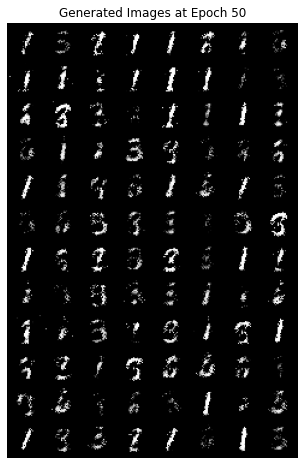

  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 50 of 100
Generator loss: 3.20869837, Discriminator loss: 0.44303463


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 51 of 100
Generator loss: 3.56993395, Discriminator loss: 0.42654713


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 52 of 100
Generator loss: 3.36465415, Discriminator loss: 0.44565549


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 53 of 100
Generator loss: 3.64708197, Discriminator loss: 0.37128334


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 54 of 100
Generator loss: 3.43259629, Discriminator loss: 0.42451099


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 55 of 100
Generator loss: 3.10556698, Discriminator loss: 0.50717662


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 56 of 100
Generator loss: 2.92279555, Discriminator loss: 0.57153497


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 57 of 100
Generator loss: 3.04501210, Discriminator loss: 0.50302087


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 58 of 100
Generator loss: 2.93308676, Discriminator loss: 0.49723387


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 59 of 100
Generator loss: 2.98254176, Discriminator loss: 0.47473008


118it [00:34,  3.39it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 60 of 100
Generator loss: 3.10245720, Discriminator loss: 0.46553023


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 61 of 100
Generator loss: 3.13816974, Discriminator loss: 0.47015513


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 62 of 100
Generator loss: 3.07854687, Discriminator loss: 0.50472300


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 63 of 100
Generator loss: 2.76404303, Discriminator loss: 0.51190475


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 64 of 100
Generator loss: 2.78179912, Discriminator loss: 0.53211224


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 65 of 100
Generator loss: 2.66212919, Discriminator loss: 0.53882074


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 66 of 100
Generator loss: 2.76586596, Discriminator loss: 0.55120655


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 67 of 100
Generator loss: 2.63568952, Discriminator loss: 0.55196830


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 68 of 100
Generator loss: 2.69640046, Discriminator loss: 0.55535701


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 69 of 100
Generator loss: 2.51144423, Discriminator loss: 0.58717613


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 70 of 100
Generator loss: 2.64345255, Discriminator loss: 0.63362023


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 71 of 100
Generator loss: 2.59063287, Discriminator loss: 0.61873462


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 72 of 100
Generator loss: 2.47800113, Discriminator loss: 0.63345387


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 73 of 100
Generator loss: 2.51149429, Discriminator loss: 0.59569296


118it [00:34,  3.39it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 74 of 100
Generator loss: 2.52162411, Discriminator loss: 0.59251306


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 75 of 100
Generator loss: 2.61412213, Discriminator loss: 0.59703272


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 76 of 100
Generator loss: 2.64542385, Discriminator loss: 0.59913916


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 77 of 100
Generator loss: 2.57876034, Discriminator loss: 0.62055087


118it [00:34,  3.40it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 78 of 100
Generator loss: 2.45443715, Discriminator loss: 0.66034315


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 79 of 100
Generator loss: 2.27240904, Discriminator loss: 0.68037210


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 80 of 100
Generator loss: 2.39810192, Discriminator loss: 0.64303019


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 81 of 100
Generator loss: 2.47435268, Discriminator loss: 0.67731586


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 82 of 100
Generator loss: 2.22817937, Discriminator loss: 0.71655891


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 83 of 100
Generator loss: 2.21420829, Discriminator loss: 0.70349833


118it [00:34,  3.44it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 84 of 100
Generator loss: 2.24107534, Discriminator loss: 0.68449906


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 85 of 100
Generator loss: 2.38955716, Discriminator loss: 0.64411851


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 86 of 100
Generator loss: 2.35003706, Discriminator loss: 0.64082851


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 87 of 100
Generator loss: 2.30498061, Discriminator loss: 0.65832490


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 88 of 100
Generator loss: 2.46557390, Discriminator loss: 0.67982034


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 89 of 100
Generator loss: 2.19989966, Discriminator loss: 0.73704245


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 90 of 100
Generator loss: 2.13949646, Discriminator loss: 0.72039069


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 91 of 100
Generator loss: 2.20160187, Discriminator loss: 0.69100145


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 92 of 100
Generator loss: 2.17675558, Discriminator loss: 0.71055150


118it [00:34,  3.43it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 93 of 100
Generator loss: 2.14136621, Discriminator loss: 0.72692422


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 94 of 100
Generator loss: 2.19306577, Discriminator loss: 0.72150910


118it [00:34,  3.42it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 95 of 100
Generator loss: 2.09158733, Discriminator loss: 0.74080776


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 96 of 100
Generator loss: 2.14118524, Discriminator loss: 0.71894436


118it [00:34,  3.41it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 97 of 100
Generator loss: 2.09398302, Discriminator loss: 0.74653745


118it [00:34,  3.45it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 98 of 100
Generator loss: 2.13297146, Discriminator loss: 0.71940015


118it [00:35,  3.37it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 99 of 100
Generator loss: 2.10592654, Discriminator loss: 0.75663576


118it [00:34,  3.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


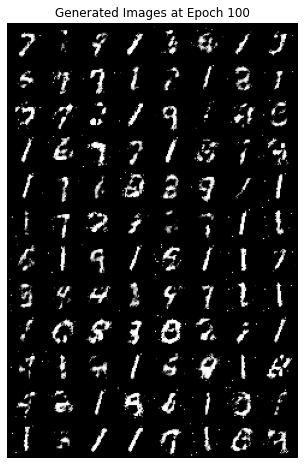

Epoch 100 of 100
Generator loss: 1.98948250, Discriminator loss: 0.77834564


In [14]:
torch.manual_seed(7777)

def add_gaussian_noise(tensor, mean=0., std=1.):
    return tensor + torch.randn(tensor.size()).to(tensor.device) * std + mean

def generator_loss(fake):
    
    return -torch.mean(torch.log(fake))
    
def discriminator_loss(fake, real):

    loss_real = -torch.mean(torch.log(real))
    loss_fake = -torch.mean(torch.log(1.0 - fake))
    return loss_real + loss_fake

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0

    ### Properly unpacking the tuple, unlike the original code ;)
    for bi, (reals_, _) in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):

        ### Discriminator step

        reals_ = reals_.to(device)
        
        batch_size_ = reals_.size(0)

        optim_d.zero_grad()

        ### Real data 
        #real_labels = label_real(batch_size_)
        ### Adding noise to my discriminator
        noisy_reals = add_gaussian_noise(reals_, std=0.05)

        output_r = discriminator(noisy_reals)

        ### Fake data, sampled from p(z) by generator class
        ### Detaching because GPT-4 told me so while bugfixing
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise).detach()
        #### Adding noise 
        
        #noisy_fakes = add_gaussian_noise(fakes, std=0.05)

        #fake_labels = label_fake(batch_size_)
        output_f = discriminator(fakes)

        ### Using the given equation
        loss_d_ = discriminator_loss(output_f, output_r)

        ### Update step
        loss_d_.backward()
        optim_d.step()
        
        loss_d += loss_d_.item()

        ### Generator tries to fool the discriminator, setting the labels to real
        optim_g.zero_grad()
        noise = create_noise(batch_size_, nz)
        fakes = generator(noise)

        output_f_g = discriminator(fakes)


        loss_g_ = generator_loss(output_f_g)

        loss_g_.backward()

        optim_g.step()

        loss_g += loss_g_.item()
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) == 1 or (epoch + 1) == 5 or (epoch + 1) == 50 or (epoch + 1) == 100 or (epoch + 1) == 150:
        plt.figure(figsize=(8,8))
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'Generated Images at Epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
# # optimizers
# optim_g = optim.Adam(generator.parameters(), lr=0.0002)
# optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images_p1b.gif', imgs)

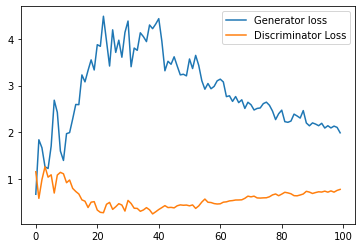

In [15]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss_p1b.png')